In [1]:
# test for cuda and cudnn
import torch
print("version", torch.__version__)
print("cuda available", torch.cuda.is_available())
print("cudnn", torch.backends.cudnn.enabled)
print("device_name", torch.cuda.get_device_name(0))
print("device count", torch.cuda.device_count())
print("current dev", torch.cuda.current_device())
print("device zero", torch.cuda.device(0))


version 2.1.2
cuda available True
cudnn True
device_name NVIDIA GeForce GTX TITAN X
device count 4
current dev 0
device zero <torch.cuda.device object at 0x7fbcc8634be0>


In [8]:
from ocatari.core import OCAtari
import random

env = OCAtari("MsPacman-v4", mode="vision", hud=True, render_mode="rgb_array")
observation, info = env.reset()
env.objects

[Player at (78, 103), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10)]

In [9]:
from ocatari.ram.extract_ram_info import detect_objects_raw, detect_objects_revised, init_objects, get_max_objects

objects = init_objects("MsPacman", True)
objects

[Player at (78, 103), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## RETRIEVE LOGS

In [115]:
import os
import shutil
import glob

# Base directory path
base_dir = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4'

# Iterate through each EXP_NAME folder
count = 0
for exp_dir in glob.glob(os.path.join(base_dir, '*')):
    version_dir = os.path.join(exp_dir, 'version_0')
    test_videos_path = os.path.join(version_dir, 'test_videos')
    memmap_buffer_path = os.path.join(version_dir, 'memmap_buffer')

    # Check if test_videos exists
    if os.path.exists(test_videos_path) and os.path.isdir(memmap_buffer_path):
        count += 1
        # Delete the contents of memmap_buffer
        for file in os.listdir(memmap_buffer_path):
            file_path = os.path.join(memmap_buffer_path, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
        # delete folder
        os.rmdir(memmap_buffer_path)

print(f"Total number of experiments processed/memmap deleted: {count}")

Total number of experiments processed/memmap deleted: 2


In [7]:
import os
import yaml
import glob

# Base directory path
base_dir = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4'

# Output file
output_path = 'extracted_info.txt'

# Open the output file once and write for each config
with open(output_path, 'w') as output_file:

    # Iterate through each EXP_NAME folder
    count = 0
    for exp_dir in glob.glob(os.path.join(base_dir, '*')):
        count += 1
        version_dir = os.path.join(exp_dir, 'version_0')
        config_path = os.path.join(version_dir, 'config.yaml')

        # Check if config.yaml exists
        if os.path.exists(config_path):
            with open(config_path, 'r') as file:
                data = yaml.safe_load(file)

            # Extracting the required values
            mlp_keys = data.get('algo', {}).get('mlp_keys', 'Not found')
            train_every = data.get('algo', {}).get('train_every', 'Not found')
            dense_units = data.get('algo', {}).get('dense_units', 'Not found')
            env_target = data.get('env', {}).get('wrapper', {}).get('env', {}).get('_target_', 'Not found')
            seed = data.get('seed', 'Not found')

            # Write to the output file
            output_file.write(f"EXP_DIR: {exp_dir}\n")
            output_file.write(f"  MLP Keys: {mlp_keys}\n")
            output_file.write(f"  Train Every: {train_every}\n")
            output_file.write(f"  Dense Units: {dense_units}\n")
            output_file.write(f"  Env Target: {env_target}\n")
            output_file.write(f"  Seed: {seed}\n\n")
        else:
            output_file.write(f"EXP_DIR: {exp_dir}\n")
            output_file.write(f"  Config not found\n\n")
    print(f"Total number of experiments: {count}")


Total number of experiments: 12


In [4]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data
path = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrameskip-v4_5/version_0/events.out.tfevents.1705922198.dalabgpu.inf.ethz.ch.3587650.0'  # Replace with your TensorBoard log directory path
df=tflog2pandas(path)
#df=df[(df.metric != 'params/lr')&(df.metric != 'params/mm')&(df.metric != 'train/loss')] #delete the mentioned rows
df.to_csv("output.csv")


In [5]:
import os
from tensorboard.backend.event_processing import event_accumulator

# Path to the TensorBoard log file
log_file_path = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrameskip-v4_5/version_0/events.out.tfevents.1705922198.dalabgpu.inf.ethz.ch.3587650.0'  # Replace with your TensorBoard log directory path

# Metrics to be extracted
AGGREGATOR_KEYS = {
    "Rewards/rew_avg",
    "Game/ep_len_avg",
    "Loss/world_model_loss",
    "Loss/value_loss",
    "Loss/policy_loss",
    "Loss/observation_loss",
    "Loss/reward_loss",
    "Loss/state_loss",
    "Loss/continue_loss",
    "State/kl",
    "State/post_entropy",
    "State/prior_entropy",
    "Params/exploration_amount",
    "Grads/world_model",
    "Grads/actor",
    "Grads/critic",
}

# Load the TensorBoard log file
ea = event_accumulator.EventAccumulator(log_file_path,
                                        size_guidance={
                                            event_accumulator.SCALARS: 0,
                                        })

ea.Reload()

# Extract and print the metrics
for key in AGGREGATOR_KEYS:
    if key in ea.scalars.Keys():
        print(f"Data for {key}:")
        for event in ea.Scalars(key):
            print(f"    Step {event.step}: {event.value}")
        print()


Data for State/post_entropy:
    Step 5000: 59.537357330322266
    Step 10000: 42.192413330078125
    Step 15000: 34.13249206542969
    Step 20000: 26.348472595214844
    Step 25000: 23.403268814086914
    Step 30000: 23.46026611328125
    Step 35000: 23.984933853149414
    Step 40000: 24.581037521362305
    Step 45000: 25.057090759277344
    Step 50000: 25.47706413269043
    Step 55000: 25.982208251953125
    Step 60000: 26.49577522277832
    Step 65000: 26.91131591796875
    Step 70000: 27.320558547973633
    Step 75000: 27.727767944335938
    Step 80000: 28.09794044494629
    Step 85000: 28.42034149169922
    Step 90000: 28.78430938720703
    Step 95000: 29.20437240600586
    Step 100000: 29.669172286987305

Data for Loss/reward_loss:
    Step 5000: 0.8023115396499634
    Step 10000: 0.1733306497335434
    Step 15000: 0.1455788016319275
    Step 20000: 0.11201032996177673
    Step 25000: 0.10557189583778381
    Step 30000: 0.11373578011989594
    Step 35000: 0.12746381759643555
    

In [59]:
from cv2 import exp
import pandas as pd
from requests import get
import yaml
from tensorboard.backend.event_processing import event_accumulator

def create_experiment_df(tensorboard_path, config_path):
    # Load TensorBoard data
    ea = event_accumulator.EventAccumulator(tensorboard_path)
    ea.Reload()

    # Load config data
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Extract parameters from config
    def get_model_size(model_size):
        if model_size == 256:
            return 'XS'
        elif model_size == 512:
            return 'S'
        else:
            return 'Not found'
        
    def get_mlp_keys(mlp_keys: dict):
        if mlp_keys['encoder'] == []:
            return 'None'
        elif mlp_keys['decoder'] == ["objects_position"]:
            return 'autoencoding'
        elif mlp_keys['encoder'] == ["objects_position"]:
            return 'enconding_only'
        else:
            return 'Not found'
        
    def get_env_target(env_target):
        if env_target == "gymnasium.make":
            return 'gym'
        elif env_target == "sheeprl.envs.ocatari.OCAtariWrapper":
            return 'ocatari'
        else:
            return 'Not found'
        

    params = {
        'seed': config.get('seed', 'Not found'),
        'objects_positions': get_mlp_keys(config.get('algo', {}).get('mlp_keys', 'Not found')),
        'train_every': config.get('algo', {}).get('train_every', 'Not found'),
        'model_size': get_model_size(config.get('algo', {}).get('dense_units', 'Not found')),
        'env_target': get_env_target(config.get('env', {}).get('wrapper', {}).get('env', {}).get('_target_', 'Not found')),
        'run_name': config.get('run_name', 'Not found'),
    }

   

    # Extract metrics and populate DataFrame
    list_of_entries = []
    for key in ea.scalars.Keys():
        # skip hp_metric
        if key == 'hp_metric':
            continue
        for event in ea.Scalars(key):
            list_of_entries.append({
                'Metric': key,
                'Step': event.step,
                'Value': event.value,
                'Seed': params['seed'],
                'MLP_Keys': params['objects_positions'],
                'Train_Every': params['train_every'],
                'Model_Size': params['model_size'],
                'Env_Target': params['env_target'],
                'Run_ID': params['run_name'],
            })
    df = pd.DataFrame.from_records(list_of_entries, columns=['Metric', 'Step', 'Value', 'Seed', 'MLP_Keys', 'Train_Every', 'Model_Size', 'Env_Target', 'Run_ID'])
    return df

# Example usage
tensorboard_file_path = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrameskip-v4_5/version_0/events.out.tfevents.1705922198.dalabgpu.inf.ethz.ch.3587650.0'  # Replace with your TensorBoard log directory path
config_file_path = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrameskip-v4_5/version_0/config.yaml'
experiment_df = create_experiment_df(tensorboard_file_path, config_file_path)

# Displaying the DataFrame
experiment_df.head(5)


,Metric,Step,Value,Seed,MLP_Keys,Train_Every,Model_Size,Env_Target,Run_ID
0,Rewards/rew_avg,5000,307.500000,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
1,Rewards/rew_avg,10000,261.250000,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
2,Rewards/rew_avg,15000,151.111115,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
3,Rewards/rew_avg,20000,206.666672,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
4,Rewards/rew_avg,25000,239.000000,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...


In [78]:
import os
import pandas as pd

def process_all_experiments(logs_base_dir, process_experiment_func: callable):
    # Pattern for TensorFlow event files and config files
    tf_event_pattern = 'events.out.tfevents.*'
    config_filename = 'config.yaml'

    # List to hold DataFrames from each experiment
    experiments_dfs = []

    # Iterate over each subdirectory in the logs directory
    for root, dirs, files in os.walk(logs_base_dir):
        for file in files:
            if file.startswith('events.out.tfevents'):
                # TensorFlow event file path
                tf_event_path = os.path.join(root, file)

                # Corresponding config file path
                config_path = os.path.join(root, config_filename)

                # Check if config file exists
                if os.path.exists(config_path):
                    experiment_df = process_experiment_func(tf_event_path, config_path)
                    experiments_dfs.append(experiment_df)

    # Concatenate all DataFrames into a single one
    all_experiments_df = pd.concat(experiments_dfs, ignore_index=True)

    return all_experiments_df

# Example usage
logs_base_dir = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/'
all_experiments_df = process_all_experiments(logs_base_dir, create_experiment_df)
all_experiments_df


,Metric,Step,Value,Seed,MLP_Keys,Train_Every,Model_Size,Env_Target,Run_ID
0,Rewards/rew_avg,5000,307.500000,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
1,Rewards/rew_avg,10000,261.250000,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
2,Rewards/rew_avg,15000,151.111115,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
3,Rewards/rew_avg,20000,206.666672,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
4,Rewards/rew_avg,25000,239.000000,5,None,8,S,gym,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...
...,...,...,...,...,...,...,...,...,...
11448,Time/sps_env_interaction,85000,417.315460,5,autoencoding,8,S,ocatari,2024-01-26_14-52-37_dreamer_v3_MsPacmanNoFrame...
11449,Time/sps_env_interaction,90000,415.974945,5,autoencoding,8,S,ocatari,2024-01-26_14-52-37_dreamer_v3_MsPacmanNoFrame...
11450,Time/sps_env_interaction,95000,413.901947,5,autoencoding,8,S,ocatari,2024-01-26_14-52-37_dreamer_v3_MsPacmanNoFrame...
11451,Time/sps_env_interaction,100000,414.155518,5,autoencoding,8,S,ocatari,2024-01-26_14-52-37_dreamer_v3_MsPacmanNoFrame...


In [79]:
# print set of unique values for Model_Size, MLP_Keys, Train_Every, Env_Target
print('Model_Size:', set(all_experiments_df['Model_Size']))
print('MLP_Keys:', set(all_experiments_df['MLP_Keys']))
print('Train_Every:', set(all_experiments_df['Train_Every']))
print('Env_Target:', set(all_experiments_df['Env_Target']))


Model_Size: {'S', 'XS'}
MLP_Keys: {'autoencoding', 'None', 'enconding_only'}
Train_Every: {8, 4}
Env_Target: {'ocatari', 'gym'}


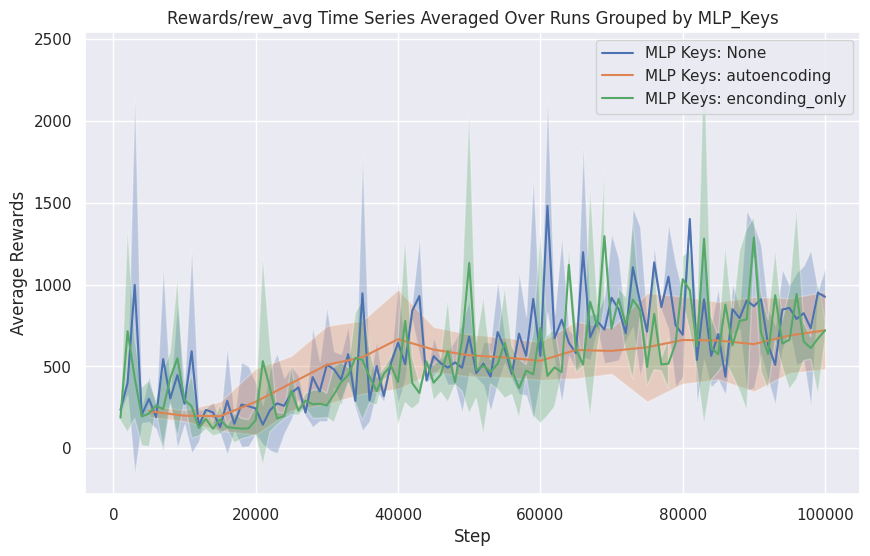

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# Filtering the DataFrame for the 'Rewards/rew_avg' metric, train_every = 8, and model_size = 'S'

filtered_df = all_experiments_df[(all_experiments_df['Metric'] == 'Rewards/rew_avg') & (all_experiments_df['Train_Every'] == 8) & (all_experiments_df['Model_Size'] == 'S')]

# Group by Step and MLP_Keys, then calculate mean and std
grouped = filtered_df.drop(columns=['Env_Target', 'Run_ID', 'Metric', 'Model_Size', 'Train_Every', 'Seed']).groupby(['Step', 'MLP_Keys'])
mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Unique MLP_Keys
mlp_keys_unique = filtered_df['MLP_Keys'].unique()

for mlp_key in mlp_keys_unique:
    subset = mean_std_df[mean_std_df['MLP_Keys'] == mlp_key]
    
    # Plot mean
    plt.plot(subset['Step'], subset['mean'], label=f'MLP Keys: {mlp_key}')
    
    # Fill between mean ± std
    plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

plt.title('Rewards/rew_avg Time Series Averaged Over Runs Grouped by MLP_Keys')
plt.xlabel('Step')
plt.ylabel('Average Rewards')
plt.legend()
plt.show()


In [106]:
# get unique 'Run_ID', 'MLP_Keys', 'Train_Every', 'Model_Size', 'Env_Target' combinations
unique_combinations = filtered_df[['Run_ID', 'MLP_Keys', 'Train_Every', 'Model_Size', 'Env_Target']].drop_duplicates()
unique_combinations

,Run_ID,MLP_Keys,Train_Every,Model_Size,Env_Target
0,2024-01-22_12-16-37_dreamer_v3_MsPacmanNoFrame...,None,8,S,gym
361,2024-01-29_10-55-53_dreamer_v3_MsPacmanNoFrame...,autoencoding,8,S,ocatari
2869,2024-02-01_10-32-08_dreamer_v3_MsPacmanNoFrame...,enconding_only,8,S,ocatari
4653,2024-01-30_20-17-54_dreamer_v3_MsPacmanNoFrame...,None,8,S,gym
6439,2024-01-30_16-58-55_dreamer_v3_MsPacmanNoFrame...,None,8,S,gym
8225,2024-01-29_10-55-25_dreamer_v3_MsPacmanNoFrame...,autoencoding,8,S,ocatari
8586,2024-01-26_14-51-41_dreamer_v3_MsPacmanNoFrame...,autoencoding,8,S,ocatari
8947,2024-01-26_14-51-01_dreamer_v3_MsPacmanNoFrame...,autoencoding,8,S,ocatari
9308,2024-02-01_10-32-32_dreamer_v3_MsPacmanNoFrame...,enconding_only,8,S,ocatari
11092,2024-01-26_14-52-37_dreamer_v3_MsPacmanNoFrame...,autoencoding,8,S,ocatari


Plotting for metric: Rewards/rew_avg


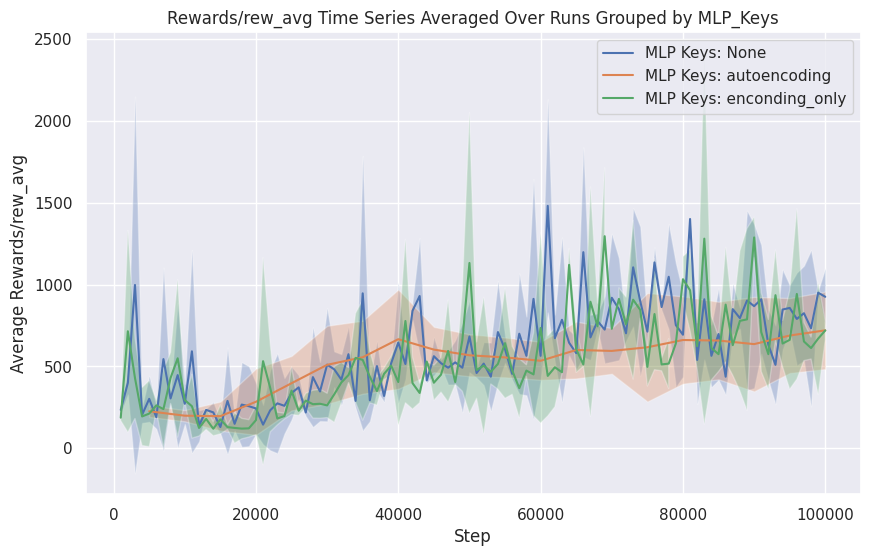

Plotting for metric: Game/ep_len_avg


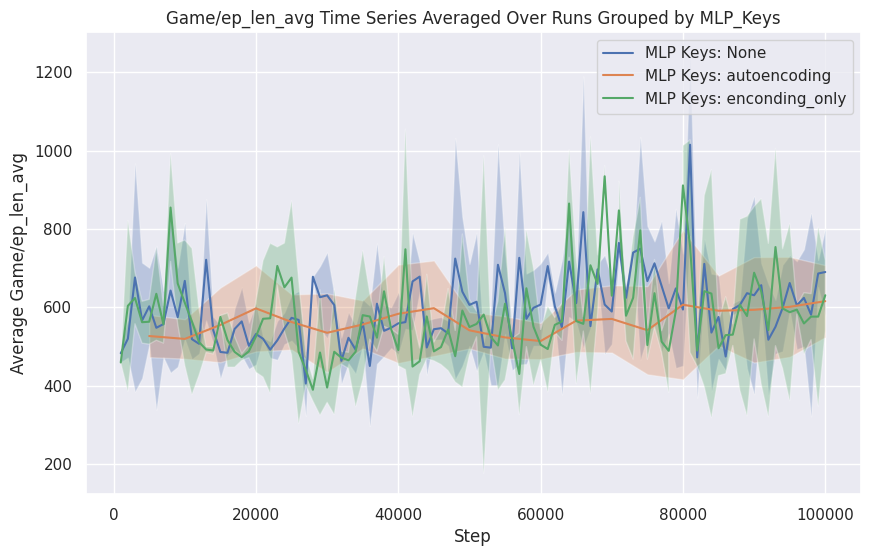

Plotting for metric: Loss/world_model_loss


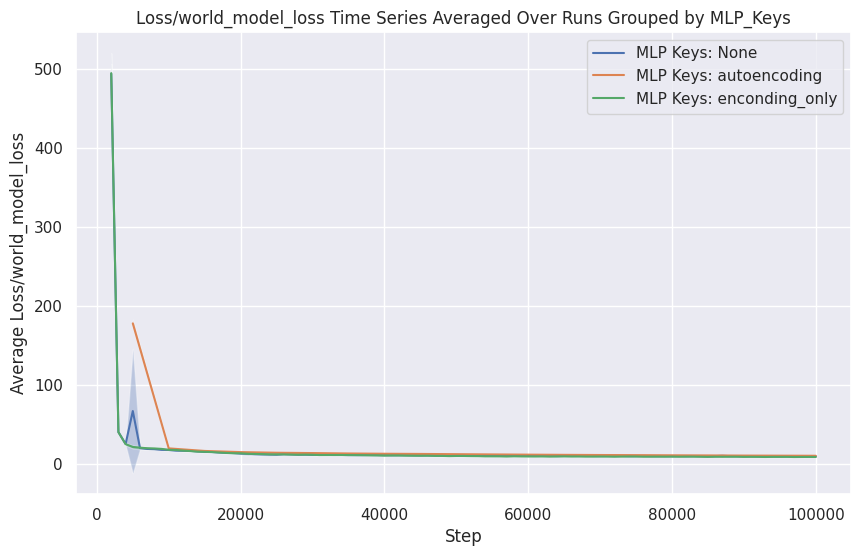

Plotting for metric: Loss/value_loss


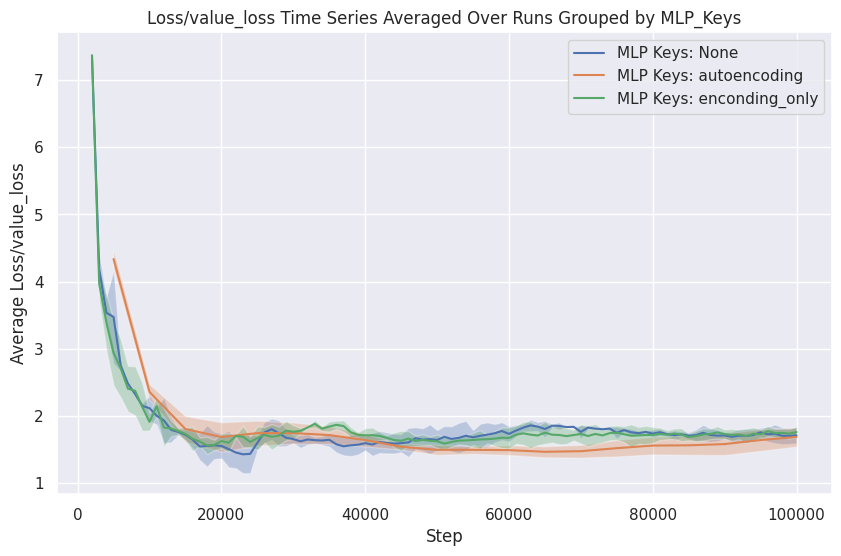

Plotting for metric: Loss/policy_loss


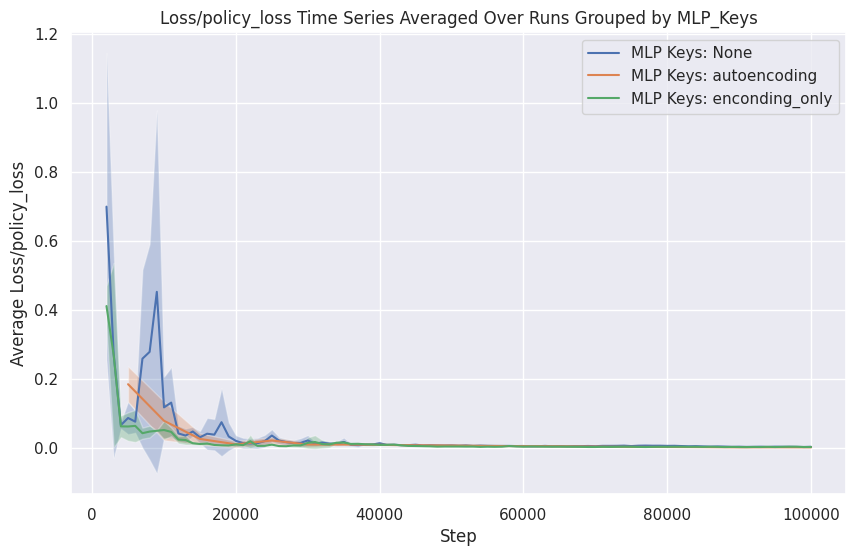

Plotting for metric: Loss/observation_loss


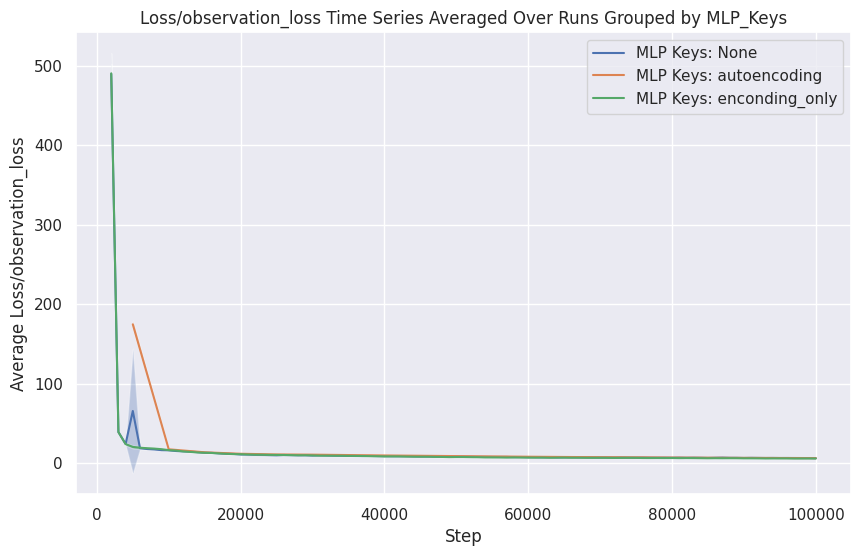

Plotting for metric: Loss/reward_loss


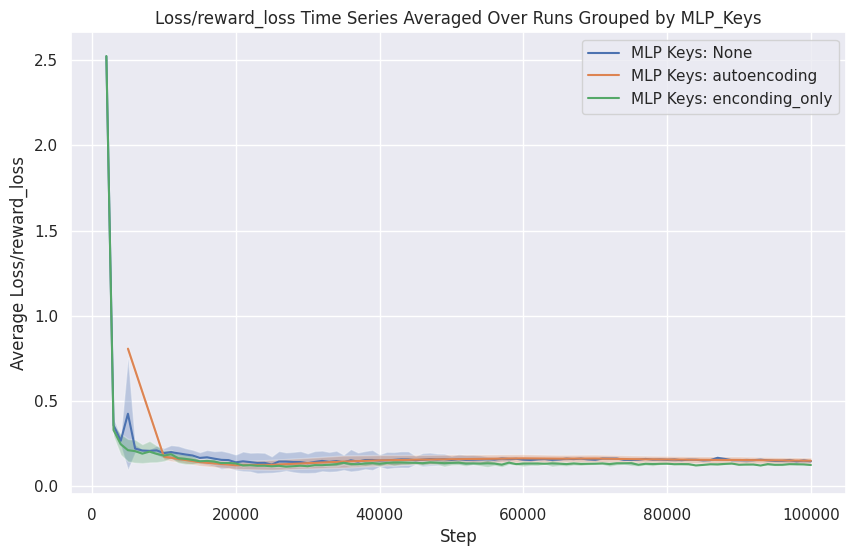

Plotting for metric: Loss/state_loss


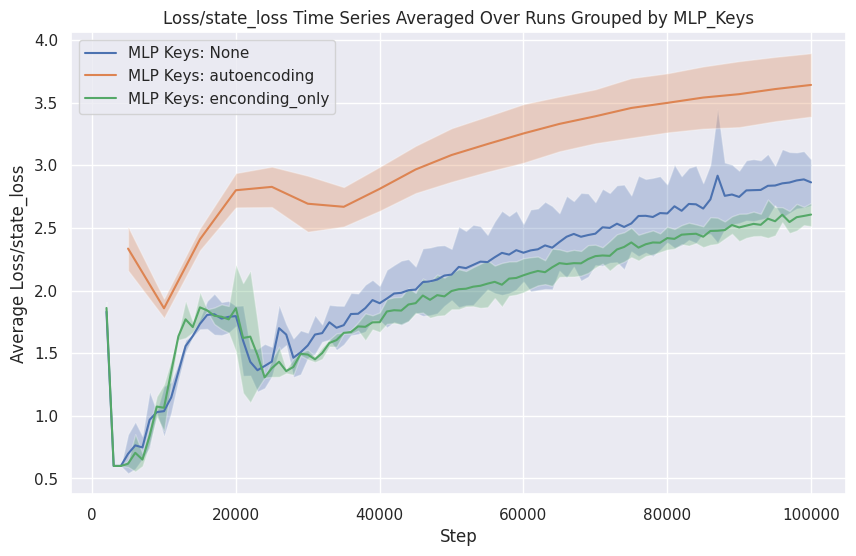

Plotting for metric: Loss/continue_loss


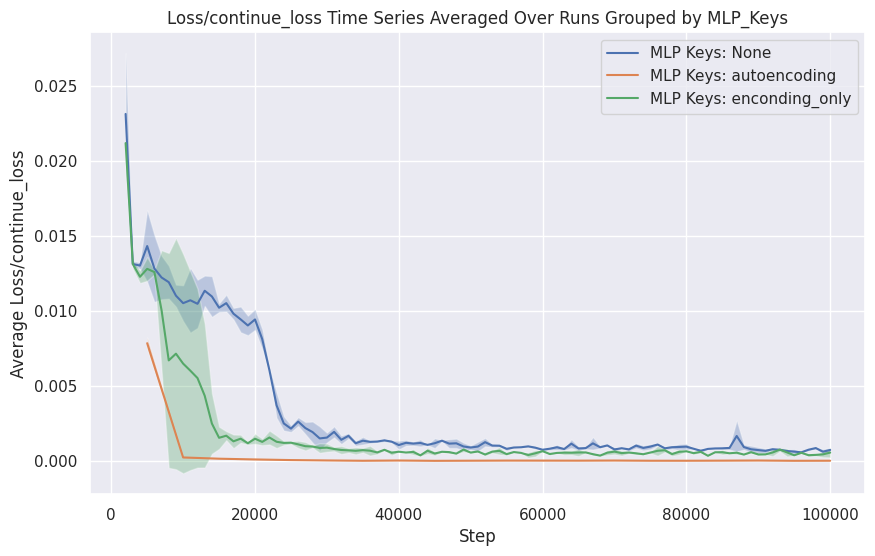

Plotting for metric: State/kl


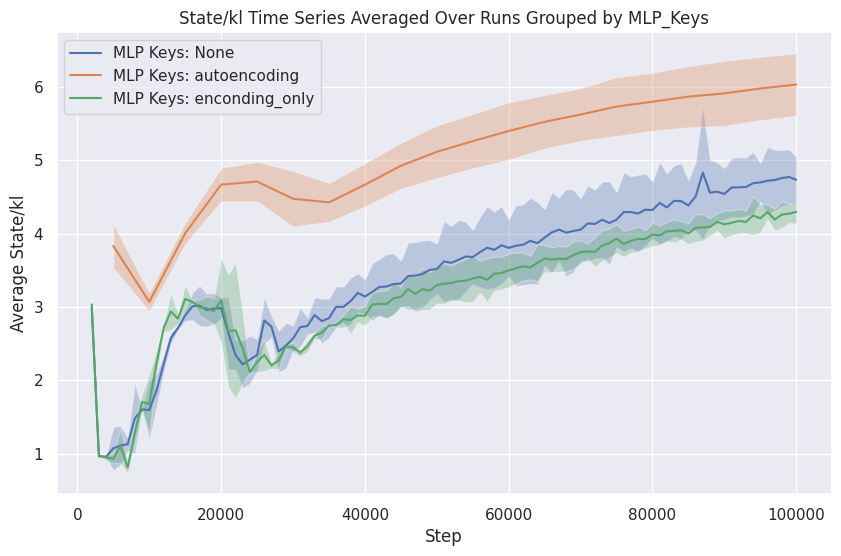

Plotting for metric: State/post_entropy


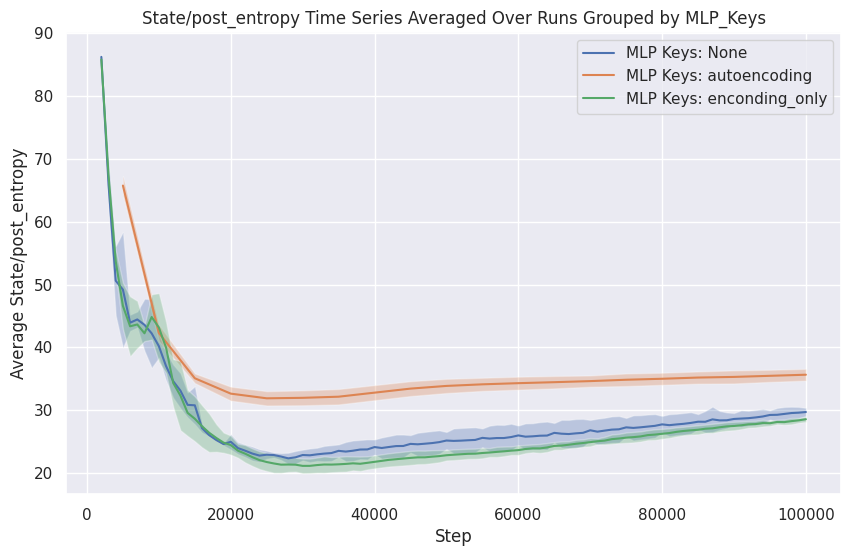

Plotting for metric: State/prior_entropy


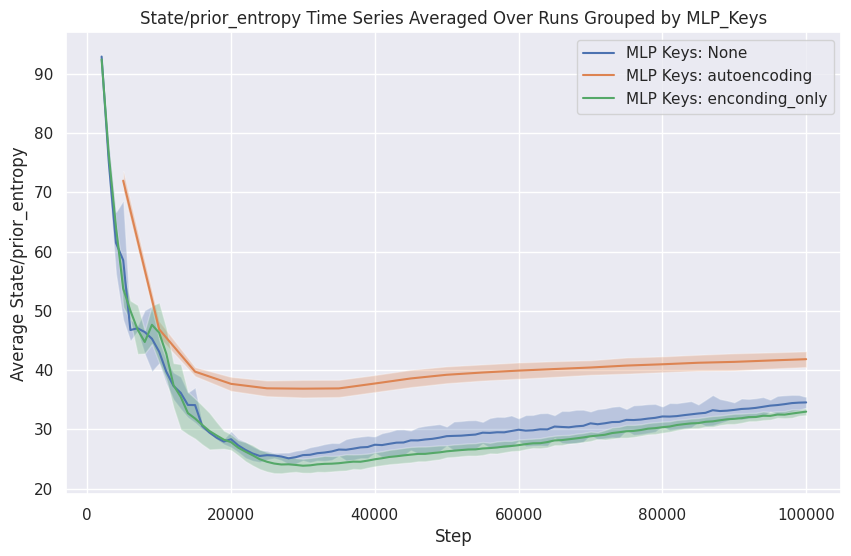

Plotting for metric: Params/exploration_amount


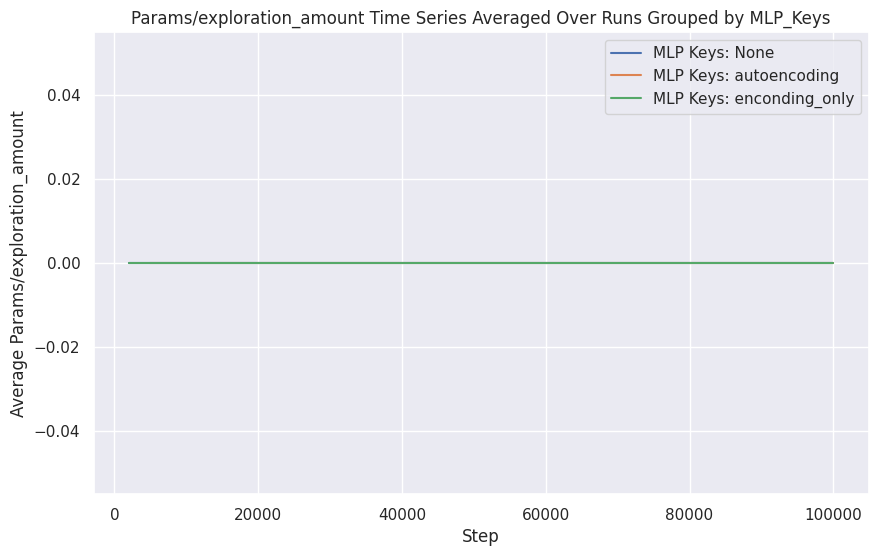

Plotting for metric: Grads/world_model


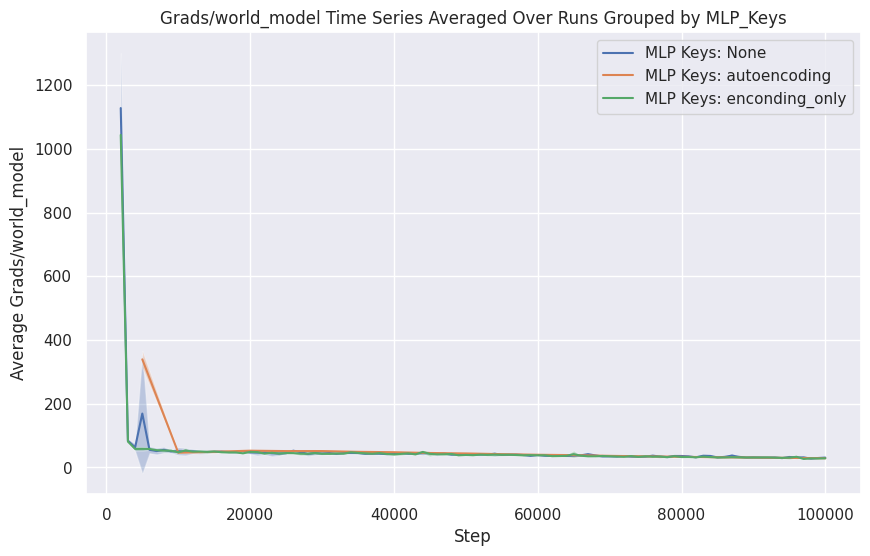

Plotting for metric: Grads/actor


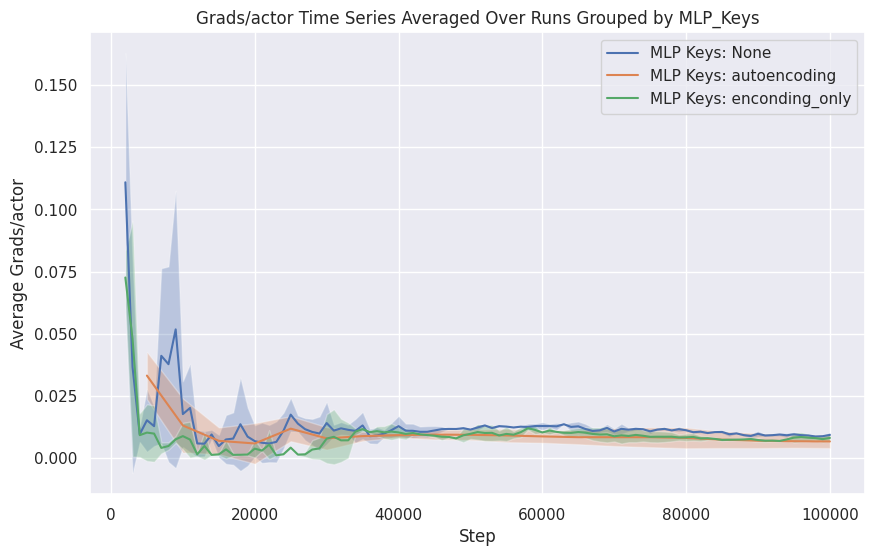

Plotting for metric: Grads/critic


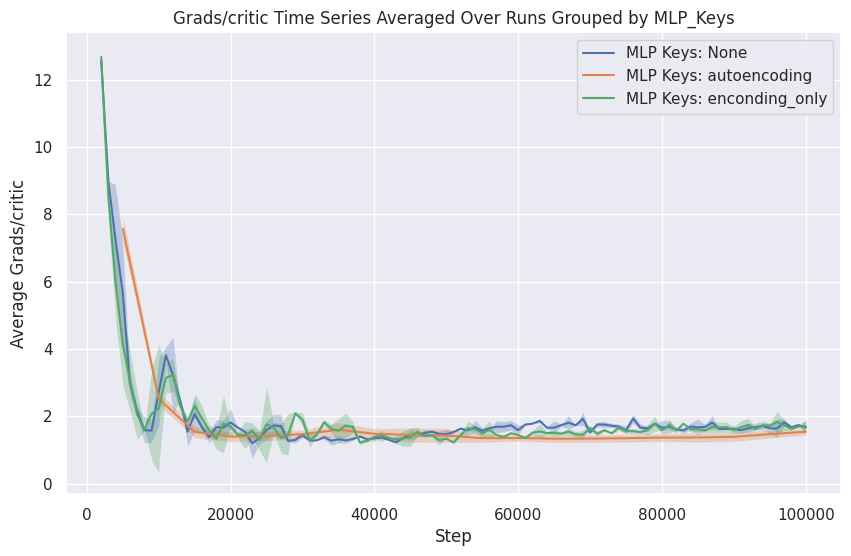

Plotting for metric: Time/sps_train


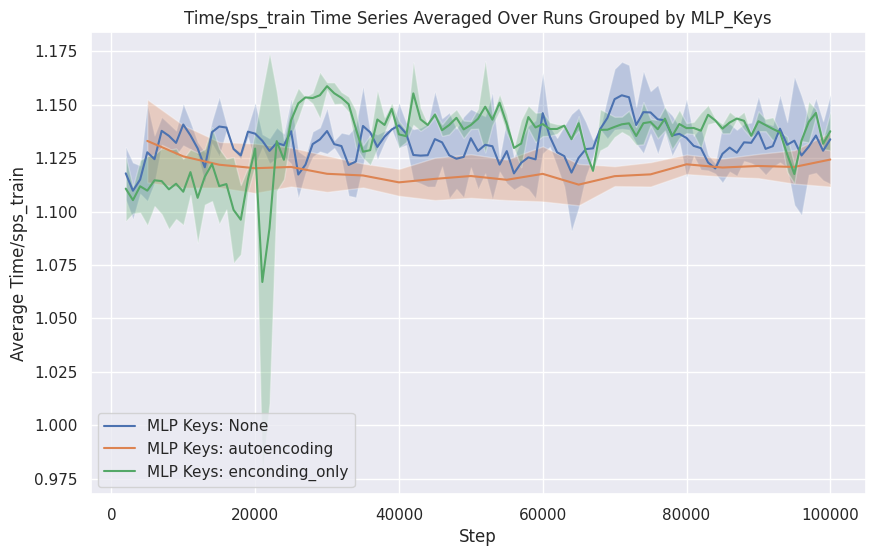

Plotting for metric: Time/sps_env_interaction


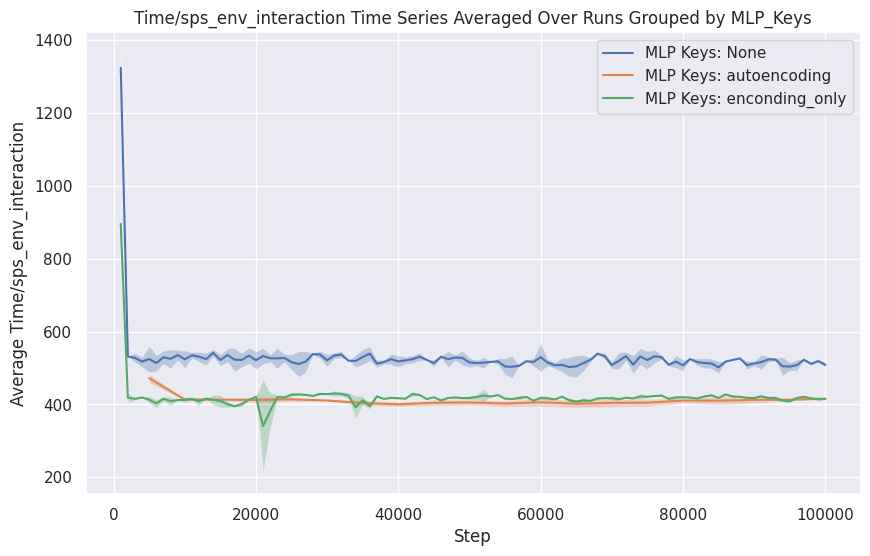

Plotting for metric: Test/cumulative_reward


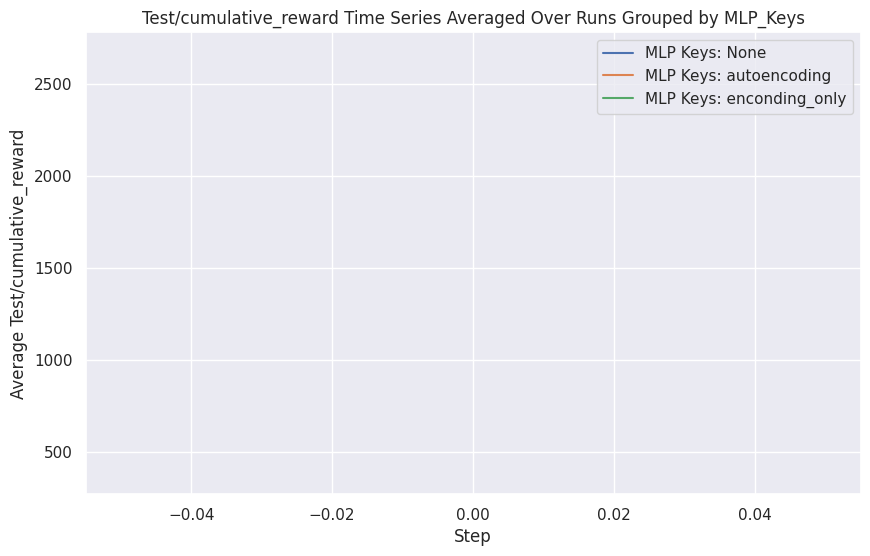

In [114]:
# Plotting for all metrics

metrics = all_experiments_df['Metric'].unique()

for metric in metrics:
    if metric == 'hp_metric':
        continue
    print(f"Plotting for metric: {metric}")
    # Group by Step and Metric, then calculate mean and std
    filtered_df = all_experiments_df[(all_experiments_df['Metric']==metric) & (all_experiments_df['Train_Every'] == 8) & (all_experiments_df['Model_Size'] == 'S')]
    grouped = filtered_df.drop(columns=['Env_Target', 'Run_ID', 'Metric', 'Model_Size', 'Train_Every', 'Seed']).groupby(['Step', 'MLP_Keys'])
    mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Unique MLP_Keys
    mlp_keys_unique = filtered_df['MLP_Keys'].unique()

    for mlp_key in mlp_keys_unique:
        subset = mean_std_df[mean_std_df['MLP_Keys'] == mlp_key]
        
        # Plot mean
        plt.plot(subset['Step'], subset['mean'], label=f'MLP Keys: {mlp_key}')
        
        # Fill between mean ± std
        plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

    plt.title(f'{metric} Time Series Averaged Over Runs Grouped by MLP_Keys')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric}')
    plt.legend()
    plt.show()